# Visualizing Overfitting and Model Complexity

In [1]:
import sys

from AppliedML.courselib.utils.metrics import accuracy, mean_squared_error
from AppliedML.courselib.utils.preprocessing import labels_encoding
from AppliedML.courselib.optimizers import GDOptimizer
import AppliedML.courselib.models.nn as nn
import AppliedML.courselib.models.svm as svm
import datagen.ConcentricBands as cc
import datagen.HalfMoons as hm
import datagen.Spirals as sp
import datagen.Spirals as sp
from models import *

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
def show_tunable_model(tunable_model, df, params_to_title, label_to_num_label, measure_accuracy, train_split=0.2, training_params=None):
    num_train_samples = int(np.floor(train_split*len(df)))
    df_train = df[:num_train_samples]
    df_test = df[num_train_samples:]
    models = tunable_model.fit(
        df_train[['x', 'y']].to_numpy(),
        label_to_num_label(df_train['label']),
        training_params=training_params
    )
    
    fig, axs = plt.subplots(1, len(models), figsize=(20, 10))
    
    x_min, x_max = df['x'].min() - 0.5, df['x'].max() + 0.5
    y_min, y_max = df['y'].min() - 0.5, df['y'].max() + 0.5
    x_list, y_list = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    X_list = np.dstack([x_list, y_list])
    
    cmap = matplotlib.colors.ListedColormap(['red', 'blue', 'green'])
    colors = df['label'].astype("category").cat.codes
    colors_train = colors[:num_train_samples]
    colors_test = colors[num_train_samples:]
    
    for ax, (model, params, metrics_history) in zip(axs.flat, models):
        ax.set_title(f"{params_to_title(params)}")
        
        h_list = model(X_list)
        
        acc_train = measure_accuracy(model, df_train)
        acc_test = measure_accuracy(model, df_test)
        ax.text(0.5, -0.1, f"Final train accuracy: {acc_train:.1f}%\nTest accuracy: {acc_test:.1f}%", 
                transform=ax.transAxes, ha='center', va='top', fontsize=12)
    
        ax.contourf(x_list, y_list, h_list, cmap=cmap, alpha=0.3)
        ax.scatter(df_test['x'], df_test['y'], c=colors_test, edgecolor='k', alpha=0.3, s=5)
        ax.scatter(df_train['x'], df_train['y'], c=colors_train, edgecolor='k')
        ax.set(aspect="equal")  
    plt.tight_layout()
    plt.show()

Seed used: 40733704


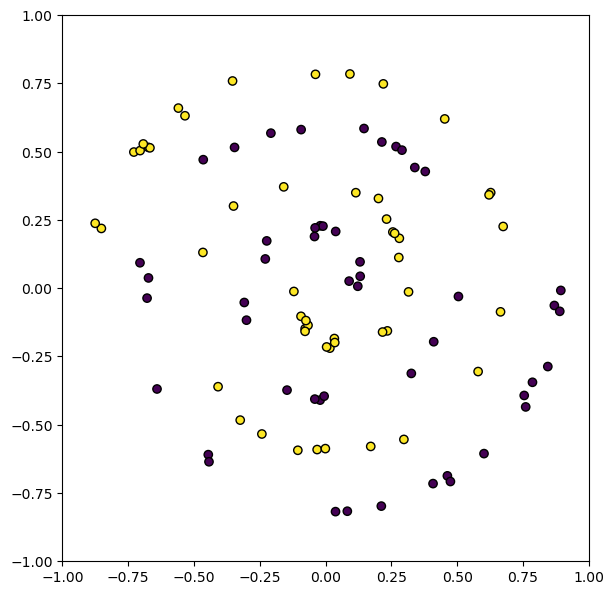

In [3]:
my_seed = 40733704 #int(random.random()*100000000)
np.random.seed(my_seed)
print("Seed used:", my_seed)

gen = sp.Spirals(sp.SpiralConf(2, 0.05, 0.1, 0.9, 2))
# gen = hm.HalfMoons([hm.HalfMoonConf(centre=(-0.2,-0.2)),
#                     hm.HalfMoonConf(angle_range=(3.14,6.29), centre=(0.2,0.2))])
#gen = cc.ConcentricBands()#[cc.CBandConf(0.7, 0.5)])
# gen = sb.RandomSeparatedBlobs()
df = gen.sample(num_samples=100)

plt.figure(figsize=(6, 6))

colors = df['label'].astype("category").cat.codes
plt.scatter(df['x'], df['y'], c=colors, edgecolor='k')

plt.tight_layout()
plt.xlim(-1,1)
plt.ylim(-1,1)

plt.show()

## Perceptrons

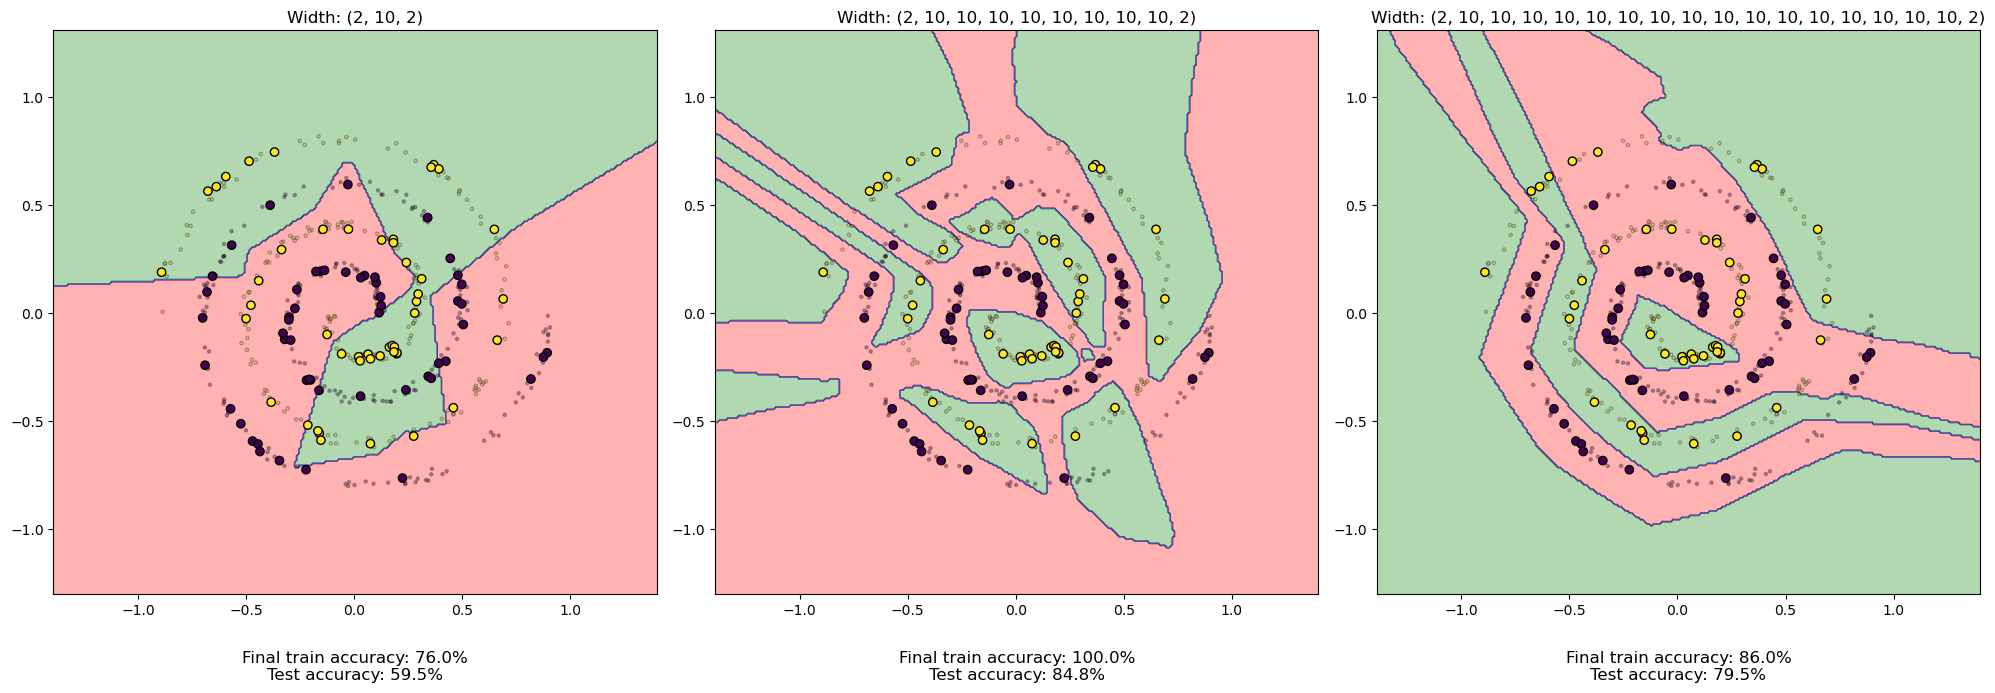

In [24]:
def get_optimizer(params):
        if params['activation'] == 'ReLU':
            return GDOptimizer(learning_rate=0.5)
        else:
            return GDOptimizer(learning_rate=5)

params = {
    'widths': list(map(lambda x: (2,)+(10,)*x+(2,), [1,8,16])),
    'activation': ["ReLU"],
    'optimizer': get_optimizer
}

tunable_model = TunableNN(
    hyperparameters=params
)

label_to_num_label = lambda ls: labels_encoding(ls.to_numpy())
measure_accuracy = (lambda model, df:
                      accuracy(model.decision_function(df[['x', 'y']].to_numpy()), 
                               label_to_num_label(df['label'])))
params_to_title = lambda params: f"Width: {params['widths']}"

df = gen.sample(num_samples=1000)
train_split = 0.2
num_batches = 5
num_epochs = 10000

show_tunable_model(tunable_model,
                   df,
                   params_to_title,
                   label_to_num_label,
                   measure_accuracy,
                   train_split=train_split,
                   training_params={'num_epochs': num_epochs,
                                    'batch_size': (len(df)*train_split)//num_batches,
                                    'compute_metrics': True,
                                    'metrics_dict': {'accuracy': accuracy, 'loss': mean_squared_error}})

## Kernel SVM

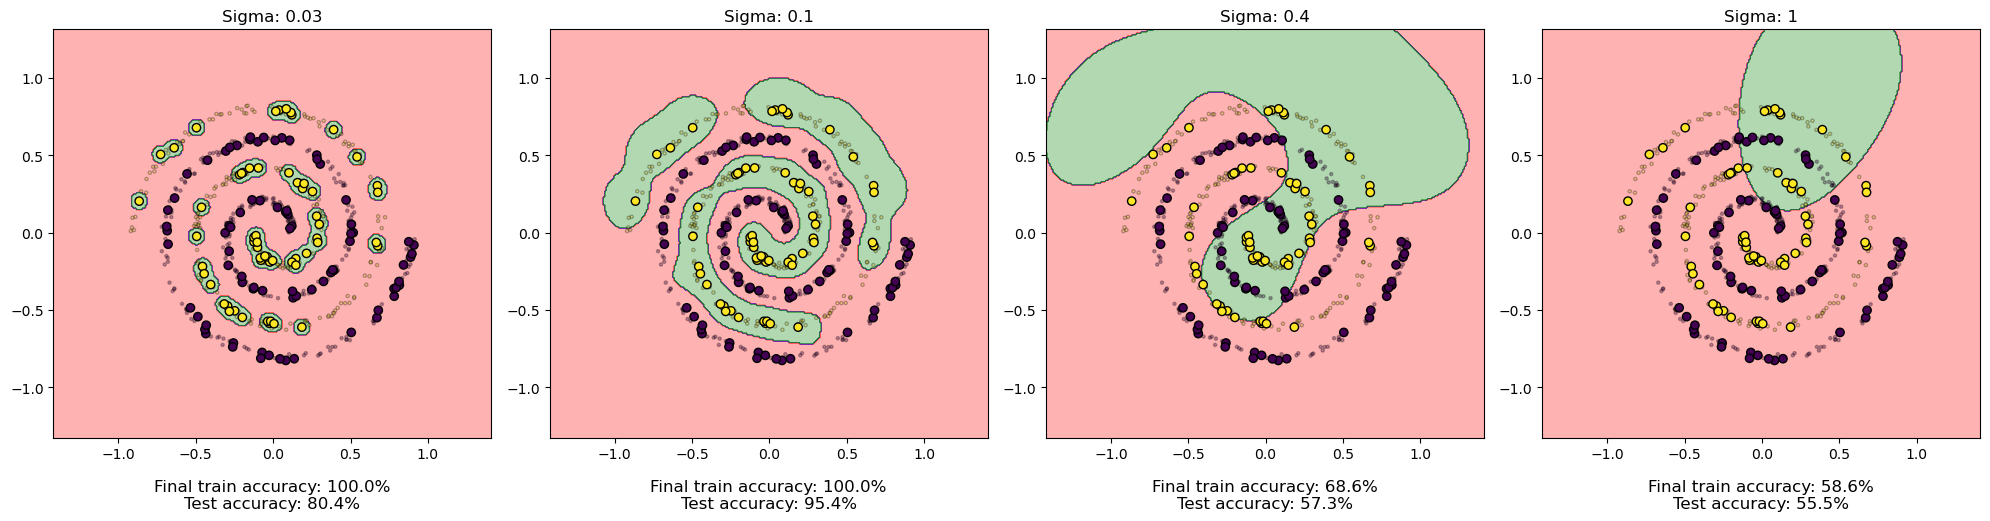

In [5]:
params = {
    'kernel': ['rbf'],
    'sigma': [0.03,0.1,0.4,1],
    'degree': range(1),
    'intercept': range(3),
}

label_to_num_label = lambda ls: ls.astype("category").cat.codes.to_numpy() * 2 - 1
measure_accuracy = (lambda model, df: accuracy(model(df[['x', 'y']].to_numpy()),
                                               label_to_num_label(df['label']),
                                               False))
params_to_title = lambda params: f"Sigma: {params['sigma']}"

tunable_model = TunableKernelSVM(
    hyperparameters=params,
)

df = gen.sample(num_samples=700)
show_tunable_model(tunable_model, df, params_to_title, label_to_num_label, measure_accuracy)

## Decision Trees